# House Prices: Advanced Regression Techniques

## Predicting Residential Property Sale Prices in Ames, Iowa

**Competition:** [Kaggle — House Prices](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)  
**Metric:** RMSE on log-transformed SalePrice  
**Target Score:** Top-10 on the public leaderboard (RMSLE ≤ 0.115)

---

### Strategy Overview


| Phase | Technique | Purpose |
|-------|-----------|----------|
| **1. EDA** | Distribution analysis, correlation study, outlier detection | Understand data structure |
| **2. Preprocessing** | Smart imputation, ordinal encoding, skewness correction | Clean & prepare data |
| **3. Feature Engineering** | 30+ engineered features: polynomials, interactions, target encoding | Maximize signal |
| **4. Modeling** | 7-model stacking ensemble (Lasso, ElasticNet, Ridge, KRR, GBR, XGB, LGB) | Diverse predictions |
| **5. Blending** | Weighted average of stack + individual boosters | Robust final prediction |

---

## 1. Environment Setup & Library Imports

In [23]:
# ============================================================
# Standard Libraries
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, norm
from scipy.special import boxcox1p
import warnings

# ============================================================
# Scikit-learn
# ============================================================
from sklearn.linear_model import Lasso, ElasticNet, Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import GradientBoostingRegressor, StackingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error

# ============================================================
# Gradient Boosting Frameworks
# ============================================================
import xgboost as xgb
import lightgbm as lgb

# ============================================================
# Configuration
# ============================================================
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 12
pd.set_option('display.max_columns', 80)

RANDOM_STATE = 42
N_FOLDS = 10

## 2. Data Loading & Initial Exploration

In [24]:
# Load datasets
train = pd.read_csv('data/train.csv', index_col='Id')
test = pd.read_csv('data/test.csv', index_col='Id')

print(f'Training set:  {train.shape[0]:,} rows × {train.shape[1]} columns')
print(f'Test set:      {test.shape[0]:,} rows × {test.shape[1]} columns')
print(f'\nTarget (SalePrice) statistics:')
print(train['SalePrice'].describe().to_string())
train.head()

Training set:  1,460 rows × 80 columns
Test set:      1,459 rows × 79 columns

Target (SalePrice) statistics:
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## 3. Exploratory Data Analysis

### 3.1 Target Variable Distribution

The target variable `SalePrice` is **right-skewed**, which is typical for price data. A **log-transformation** normalizes the distribution and stabilizes variance — this is critical since the competition metric evaluates on log(SalePrice).

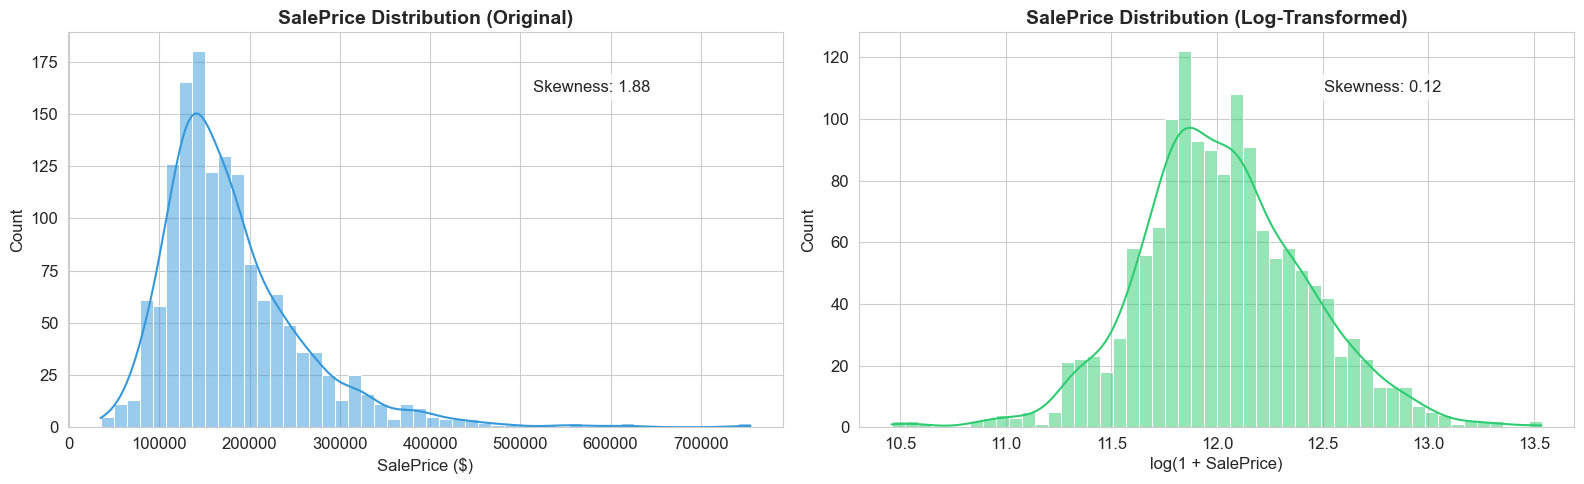


Log-transform reduces skewness from 1.88 → 0.12


In [25]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Original distribution
sns.histplot(train['SalePrice'], kde=True, ax=axes[0], color='#3498db', bins=50)
axes[0].set_title('SalePrice Distribution (Original)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('SalePrice ($)')
skew_orig = train['SalePrice'].skew()
axes[0].annotate(f'Skewness: {skew_orig:.2f}', xy=(0.65, 0.85), 
                 xycoords='axes fraction', fontsize=12,
                 bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

# Log-transformed distribution
log_price = np.log1p(train['SalePrice'])
sns.histplot(log_price, kde=True, ax=axes[1], color='#2ecc71', bins=50)
axes[1].set_title('SalePrice Distribution (Log-Transformed)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('log(1 + SalePrice)')
skew_log = log_price.skew()
axes[1].annotate(f'Skewness: {skew_log:.2f}', xy=(0.65, 0.85), 
                 xycoords='axes fraction', fontsize=12,
                 bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

print(f'\nLog-transform reduces skewness from {skew_orig:.2f} → {skew_log:.2f}')

### 3.2 Top Correlated Features

We identify the features most strongly correlated with SalePrice to guide our feature engineering.

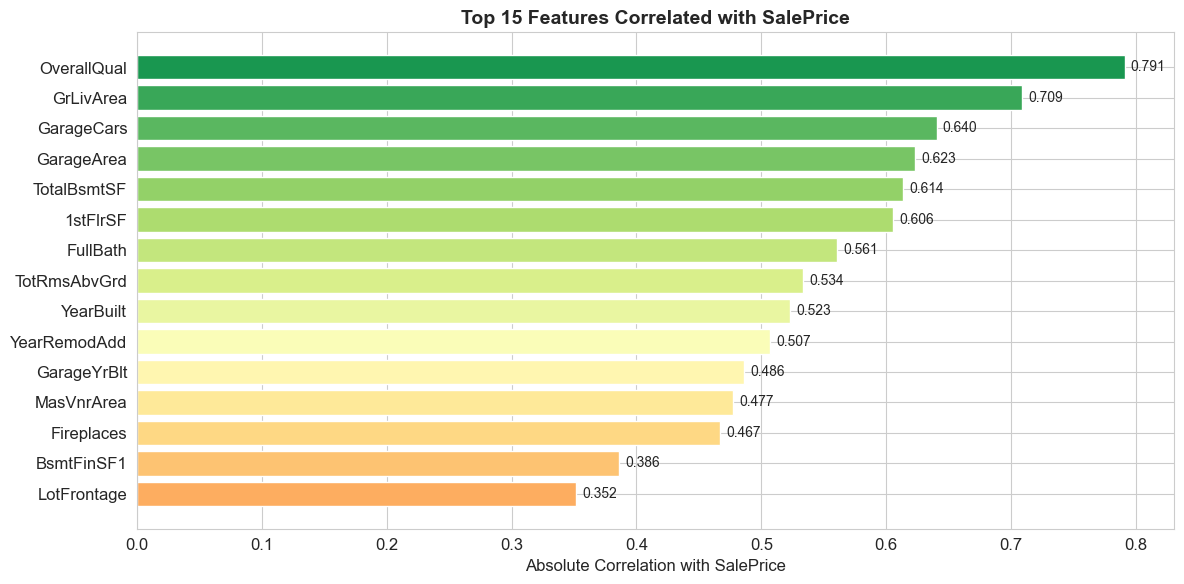


Key insight: OverallQual and GrLivArea are the strongest predictors.


In [26]:
# Top 15 correlations with SalePrice
numeric_cols = train.select_dtypes(include=[np.number]).columns
correlations = train[numeric_cols].corr()['SalePrice'].drop('SalePrice').abs().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(12, 6))
top_15 = correlations.head(15)
colors = plt.cm.RdYlGn(np.linspace(0.9, 0.3, 15))
bars = ax.barh(range(len(top_15)), top_15.values, color=colors)
ax.set_yticks(range(len(top_15)))
ax.set_yticklabels(top_15.index)
ax.set_xlabel('Absolute Correlation with SalePrice')
ax.set_title('Top 15 Features Correlated with SalePrice', fontsize=14, fontweight='bold')
ax.invert_yaxis()

for bar, val in zip(bars, top_15.values):
    ax.text(val + 0.005, bar.get_y() + bar.get_height()/2, f'{val:.3f}', 
            va='center', fontsize=10)

plt.tight_layout()
plt.show()

print('\nKey insight: OverallQual and GrLivArea are the strongest predictors.')

### 3.3 Outlier Detection

Following the advice of the dataset creator (Dean De Cock), we remove **2 outliers** with GrLivArea > 4,000 sqft but SalePrice < $300,000 — these are known anomalies.

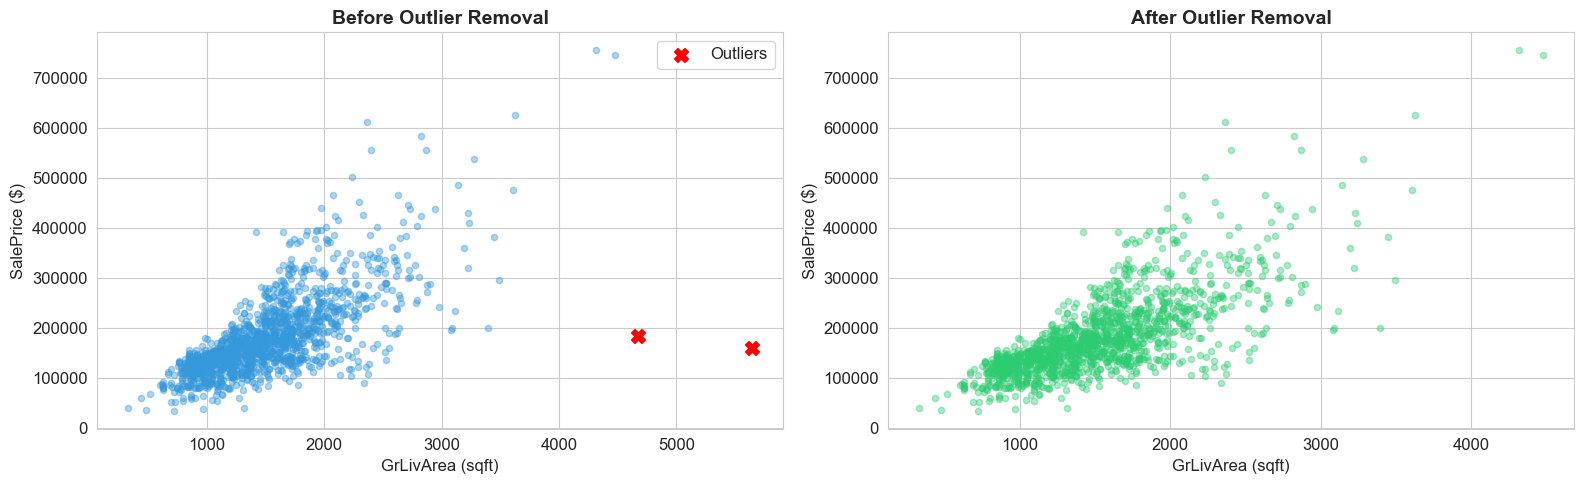


Removed 2 outliers (1460 → 1458 rows)


In [27]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Before outlier removal
axes[0].scatter(train['GrLivArea'], train['SalePrice'], c='#3498db', alpha=0.4, s=20)
outlier_mask = (train['GrLivArea'] > 4000) & (train['SalePrice'] < 300000)
axes[0].scatter(train.loc[outlier_mask, 'GrLivArea'], 
                train.loc[outlier_mask, 'SalePrice'], 
                c='red', s=100, marker='X', zorder=5, label='Outliers')
axes[0].set_title('Before Outlier Removal', fontsize=14, fontweight='bold')
axes[0].set_xlabel('GrLivArea (sqft)')
axes[0].set_ylabel('SalePrice ($)')
axes[0].legend()

# Remove outliers
n_before = len(train)
train = train.drop(train[outlier_mask].index)
n_after = len(train)

# After outlier removal
axes[1].scatter(train['GrLivArea'], train['SalePrice'], c='#2ecc71', alpha=0.4, s=20)
axes[1].set_title('After Outlier Removal', fontsize=14, fontweight='bold')
axes[1].set_xlabel('GrLivArea (sqft)')
axes[1].set_ylabel('SalePrice ($)')

plt.tight_layout()
plt.show()

print(f'\nRemoved {n_before - n_after} outliers ({n_before} → {n_after} rows)')

### 3.4 Missing Value Analysis

In [28]:
# Combine for unified missing analysis
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = np.log1p(train['SalePrice'].values)

all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)

# Missing values summary
total_missing = all_data.isnull().sum().sort_values(ascending=False)
pct_missing = (total_missing / len(all_data)) * 100
missing_df = pd.DataFrame({'Total': total_missing, 'Percent': pct_missing})
missing_df = missing_df[missing_df['Total'] > 0]

print(f'Features with missing values: {len(missing_df)} out of {all_data.shape[1]}')
print(f'\n{"Feature":<20} {"Missing":>8} {"Pct":>8}')
print('-' * 38)
for feat, row in missing_df.iterrows():
    print(f'{feat:<20} {int(row["Total"]):>8} {row["Percent"]:>7.1f}%')

Features with missing values: 34 out of 79

Feature               Missing      Pct
--------------------------------------
PoolQC                   2908    99.7%
MiscFeature              2812    96.4%
Alley                    2719    93.2%
Fence                    2346    80.4%
MasVnrType               1766    60.5%
FireplaceQu              1420    48.7%
LotFrontage               486    16.7%
GarageYrBlt               159     5.5%
GarageFinish              159     5.5%
GarageQual                159     5.5%
GarageCond                159     5.5%
GarageType                157     5.4%
BsmtExposure               82     2.8%
BsmtCond                   82     2.8%
BsmtQual                   81     2.8%
BsmtFinType2               80     2.7%
BsmtFinType1               79     2.7%
MasVnrArea                 23     0.8%
MSZoning                    4     0.1%
BsmtHalfBath                2     0.1%
Utilities                   2     0.1%
BsmtFullBath                2     0.1%
Functional          

## 4. Data Preprocessing

### 4.1 Missing Value Imputation

Our imputation strategy is driven by the **data description**:
- **"NA" means absence** (no pool, no garage, no basement) → fill with `'None'` or `0`
- **Truly missing** values → fill with mode (categorical) or neighborhood median (numerical)
- **LotFrontage** → impute using the **neighborhood median** (lots in the same neighborhood tend to have similar frontage)

In [29]:
# ============================================================
# 4.1a  LotFrontage — Neighborhood median imputation
# ============================================================
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(
    lambda x: x.fillna(x.median()))

# ============================================================
# 4.1b  Categorical features where NA means "absent"
# ============================================================
none_cols = [
    'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu',
    'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
    'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
    'BsmtFinType2', 'MasVnrType'
]
for col in none_cols:
    all_data[col] = all_data[col].fillna('None')

# ============================================================
# 4.1c  Numeric features where NA means "zero"
# ============================================================
zero_cols = [
    'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2',
    'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath',
    'MasVnrArea'
]
for col in zero_cols:
    all_data[col] = all_data[col].fillna(0)

# ============================================================
# 4.1d  GarageYrBlt — Correct typo & fill with YearBuilt
# ============================================================
all_data.loc[all_data['GarageYrBlt'] == 2207, 'GarageYrBlt'] = 2007
all_data['GarageYrBlt'] = all_data['GarageYrBlt'].fillna(all_data['YearBuilt'])

# ============================================================
# 4.1e  Remaining categoricals — mode imputation
# ============================================================
mode_cols = ['Electrical', 'KitchenQual', 'MSZoning', 'Exterior1st',
             'Exterior2nd', 'SaleType', 'Functional']
for col in mode_cols:
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

# ============================================================
# 4.1f  Drop near-zero-variance features
# ============================================================
all_data.drop(['Utilities', 'Street'], axis=1, inplace=True, errors='ignore')

# Convert MSSubClass to string (it's a categorical code, not numeric)
all_data['MSSubClass'] = all_data['MSSubClass'].astype(str)

remaining_na = all_data.isnull().sum().sum()
print(f'Imputation complete. Remaining NaN values: {remaining_na}')

Imputation complete. Remaining NaN values: 0


## 5. Feature Engineering

This is the **most impactful phase** for leaderboard performance. We create **domain-driven features** that capture how home buyers actually value properties.

### 5.1 Composite Area Features

In [30]:
# ============================================================
# Total livable square footage (strongest single predictor)
# ============================================================
all_data['TotalSF'] = (
    all_data['TotalBsmtSF'] + 
    all_data['1stFlrSF'] + 
    all_data['2ndFlrSF']
)

# Total porch area
all_data['TotalPorchSF'] = (
    all_data['OpenPorchSF'] + 
    all_data['EnclosedPorch'] + 
    all_data['3SsnPorch'] + 
    all_data['ScreenPorch'] +
    all_data['WoodDeckSF']
)

# Total bathrooms (full = 1.0, half = 0.5)
all_data['TotalBathrooms'] = (
    all_data['FullBath'] + 
    0.5 * all_data['HalfBath'] + 
    all_data['BsmtFullBath'] + 
    0.5 * all_data['BsmtHalfBath']
)

print('Area features created: TotalSF, TotalPorchSF, TotalBathrooms')

Area features created: TotalSF, TotalPorchSF, TotalBathrooms


### 5.2 Binary Indicator Features

Binary features capture the *presence/absence* of amenities, which often has a non-linear effect on price.

In [31]:
# Binary indicators
all_data['HasPool'] = (all_data['PoolArea'] > 0).astype(int)
all_data['HasGarage'] = (all_data['GarageArea'] > 0).astype(int)
all_data['Has2ndFloor'] = (all_data['2ndFlrSF'] > 0).astype(int)
all_data['HasFireplace'] = (all_data['Fireplaces'] > 0).astype(int)
all_data['HasBsmt'] = (all_data['TotalBsmtSF'] > 0).astype(int)
all_data['HasMasVnr'] = (all_data['MasVnrArea'] > 0).astype(int)
all_data['HasWoodDeck'] = (all_data['WoodDeckSF'] > 0).astype(int)
all_data['HasOpenPorch'] = (all_data['OpenPorchSF'] > 0).astype(int)
all_data['WasRemodeled'] = (all_data['YearRemodAdd'] != all_data['YearBuilt']).astype(int)
all_data['IsNewHouse'] = (all_data['YrSold'] == all_data['YearBuilt']).astype(int)

print(f'Created 10 binary indicator features')

Created 10 binary indicator features


### 5.3 Temporal Features

Age-related features capture depreciation and renovation effects.

In [32]:
# Age at time of sale
all_data['HouseAge'] = all_data['YrSold'] - all_data['YearBuilt']
all_data['YearsSinceRemodel'] = all_data['YrSold'] - all_data['YearRemodAdd']
all_data['GarageAge'] = all_data['YrSold'] - all_data['GarageYrBlt']

# Clip negative ages (can occur from data entry issues)
all_data['HouseAge'] = all_data['HouseAge'].clip(lower=0)
all_data['YearsSinceRemodel'] = all_data['YearsSinceRemodel'].clip(lower=0)
all_data['GarageAge'] = all_data['GarageAge'].clip(lower=0)

print('Temporal features created: HouseAge, YearsSinceRemodel, GarageAge')

Temporal features created: HouseAge, YearsSinceRemodel, GarageAge


### 5.4 Polynomial & Interaction Features

These capture the **non-linear relationship** between quality/size and price. OverallQual is the strongest predictor — its squared and cubed terms significantly improve model performance.

In [33]:
# Polynomial features for top predictors
all_data['OverallQual_2'] = all_data['OverallQual'] ** 2
all_data['OverallQual_3'] = all_data['OverallQual'] ** 3
all_data['GrLivArea_2'] = all_data['GrLivArea'] ** 2
all_data['TotalSF_2'] = all_data['TotalSF'] ** 2

# Key interactions (Quality × Size = "value")
all_data['QualXArea'] = all_data['OverallQual'] * all_data['GrLivArea']
all_data['QualXTotalSF'] = all_data['OverallQual'] * all_data['TotalSF']
all_data['QualXGarageArea'] = all_data['OverallQual'] * all_data['GarageArea']
all_data['GarageCarsByArea'] = all_data['GarageCars'] * all_data['GarageArea']
all_data['TotalBath_x_Qual'] = all_data['TotalBathrooms'] * all_data['OverallQual']

# Finished basement ratio
all_data['BsmtFinRatio'] = np.where(
    all_data['TotalBsmtSF'] > 0,
    (all_data['BsmtFinSF1'] + all_data['BsmtFinSF2']) / all_data['TotalBsmtSF'],
    0
)

print('Created 10 polynomial & interaction features')

Created 10 polynomial & interaction features


### 5.5 Target Encoding for Neighborhood

Neighborhood is one of the strongest categorical predictors. We use **target encoding** (mean of log SalePrice per neighborhood) computed on training data only to avoid leakage.

In [34]:
# Target encoding: computed from TRAINING data only
nbhd_means = train.groupby('Neighborhood')['SalePrice'].apply(
    lambda x: np.log1p(x).mean()
)
all_data['Neighborhood_TE'] = all_data['Neighborhood'].map(nbhd_means)
all_data['Neighborhood_TE'] = all_data['Neighborhood_TE'].fillna(
    np.log1p(train['SalePrice']).mean()
)

print(f'Target encoding for Neighborhood: {len(nbhd_means)} unique values mapped.')
print(f'   Range: {nbhd_means.min():.3f} (cheapest) → {nbhd_means.max():.3f} (most expensive)')

Target encoding for Neighborhood: 25 unique values mapped.
   Range: 11.447 (cheapest) → 12.676 (most expensive)


## 6. Ordinal Encoding & Skewness Correction

### 6.1 Ordinal Encoding

Quality features have a natural ordering (Ex > Gd > TA > Fa > Po). Ordinal encoding preserves this ordering, which is more informative than one-hot encoding for tree-based and linear models.

In [35]:
# ============================================================
# Quality / Condition mappings
# ============================================================
qual_map = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0, 'NA': 0}
qual_cols = [
    'ExterQual', 'ExterCond', 'KitchenQual', 'HeatingQC',
    'BsmtQual', 'BsmtCond', 'FireplaceQu', 'GarageQual',
    'GarageCond', 'PoolQC'
]
for col in qual_cols:
    if col in all_data.columns:
        all_data[col] = all_data[col].map(qual_map).fillna(0)

# Basement exposure
bsmt_exp_map = {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'None': 0}
all_data['BsmtExposure'] = all_data['BsmtExposure'].map(bsmt_exp_map).fillna(0)

# Basement finish type
bsmt_fin_map = {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'None': 0}
for col in ['BsmtFinType1', 'BsmtFinType2']:
    all_data[col] = all_data[col].map(bsmt_fin_map).fillna(0)

# Functional rating
func_map = {'Typ': 7, 'Min1': 6, 'Min2': 5, 'Mod': 4, 'Maj1': 3, 'Maj2': 2, 'Sev': 1, 'Sal': 0}
all_data['Functional'] = all_data['Functional'].map(func_map).fillna(7)

# Garage finish
gar_fin_map = {'Fin': 3, 'RFn': 2, 'Unf': 1, 'None': 0}
all_data['GarageFinish'] = all_data['GarageFinish'].map(gar_fin_map).fillna(0)

# Fence quality
fence_map = {'GdPrv': 4, 'MnPrv': 3, 'GdWo': 2, 'MnWw': 1, 'None': 0}
all_data['Fence'] = all_data['Fence'].map(fence_map).fillna(0)

# Lot shape
lot_shape_map = {'Reg': 3, 'IR1': 2, 'IR2': 1, 'IR3': 0}
all_data['LotShape'] = all_data['LotShape'].map(lot_shape_map).fillna(0)

# Paved drive
paved_map = {'Y': 2, 'P': 1, 'N': 0}
all_data['PavedDrive'] = all_data['PavedDrive'].map(paved_map).fillna(0)

print('Ordinal encoding applied to quality/condition features.')

Ordinal encoding applied to quality/condition features.


### 6.2 Skewness Correction (Box-Cox Transformation)

Highly skewed numeric features can degrade linear model performance. We apply the **Box-Cox transformation** (λ=0.15) to features with |skewness| > 0.75.

In [36]:
# Identify skewed features
numeric_feats = all_data.dtypes[all_data.dtypes != 'object'].index
skewed_feats = all_data[numeric_feats].apply(
    lambda x: skew(x.dropna())
).sort_values(ascending=False)

skewness = pd.DataFrame({'Skew': skewed_feats})
high_skew = skewness[abs(skewness['Skew']) > 0.75]

print(f'Features with |skewness| > 0.75: {high_skew.shape[0]} out of {len(numeric_feats)}')

# Apply Box-Cox transformation
lam = 0.15
for feat in high_skew.index:
    all_data[feat] = boxcox1p(all_data[feat], lam)

print(f'Box-Cox(lambda={lam}) applied to {high_skew.shape[0]} features.')

Features with |skewness| > 0.75: 47 out of 80
Box-Cox(lambda=0.15) applied to 47 features.


### 6.3 One-Hot Encoding for Remaining Categoricals

In [37]:
# One-hot encode remaining categorical features
all_data = pd.get_dummies(all_data)

# Split back
train_processed = all_data[:ntrain].copy()
test_processed = all_data[ntrain:].copy()

# Fill any remaining NaN in test with 0
train_processed = train_processed.fillna(0)
test_processed = test_processed.fillna(0)

print(f'Final feature matrix: {all_data.shape[1]} features')
print(f'   Training:  {train_processed.shape}')
print(f'   Test:      {test_processed.shape}')

Final feature matrix: 265 features
   Training:  (1458, 265)
   Test:      (1459, 265)


## 7. Model Training & Evaluation

### 7.1 Cross-Validation Framework

We use **10-fold cross-validation** with RMSE on log(SalePrice) as the metric, matching the competition evaluation.

In [38]:
kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

def cv_rmse(model, X, y):
    """Compute cross-validated RMSE."""
    rmse = np.sqrt(-cross_val_score(
        model, X, y, 
        scoring='neg_mean_squared_error', 
        cv=kf
    ))
    return rmse

print(f'{N_FOLDS}-fold CV framework ready.')

10-fold CV framework ready.


### 7.2 Base Model Definitions

We define **7 diverse base learners** spanning different model families for maximum ensemble diversity:

| Model | Family | Strength |
|-------|--------|----------|
| Lasso | L1 Linear | Feature selection, interpretable |
| ElasticNet | L1+L2 Linear | Handles multicollinearity |
| Ridge | L2 Linear | Stable, low variance |
| Kernel Ridge | Kernel | Captures non-linear patterns |
| GBR | Gradient Boosting | Huber loss = robust to outliers |
| XGBoost | Gradient Boosting | Regularized, fast |
| LightGBM | Gradient Boosting | Leaf-wise, efficient |

In [39]:
# ============================================================
# Linear Models (with RobustScaler for outlier resistance)
# ============================================================
lasso = make_pipeline(
    RobustScaler(), 
    Lasso(alpha=0.0005, random_state=1, max_iter=10000)
)

enet = make_pipeline(
    RobustScaler(), 
    ElasticNet(alpha=0.0005, l1_ratio=0.9, random_state=3, max_iter=10000)
)

ridge = make_pipeline(
    RobustScaler(), 
    Ridge(alpha=10.0)
)

# ============================================================
# Kernel Ridge Regression
# ============================================================
krr = make_pipeline(
    RobustScaler(), 
    KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
)

# ============================================================
# Gradient Boosting (Huber loss for robustness)
# ============================================================
gbr = GradientBoostingRegressor(
    n_estimators=3000, 
    learning_rate=0.05, 
    max_depth=4,
    max_features='sqrt', 
    min_samples_leaf=15, 
    min_samples_split=10,
    loss='huber', 
    random_state=5
)

# ============================================================
# XGBoost
# ============================================================
xgb_model = xgb.XGBRegressor(
    colsample_bytree=0.4603, 
    gamma=0.0468,
    learning_rate=0.05, 
    max_depth=3,
    min_child_weight=1.7817, 
    n_estimators=2200,
    reg_alpha=0.4640, 
    reg_lambda=0.8571,
    subsample=0.5213, 
    random_state=7, 
    n_jobs=-1, 
    verbosity=0
)

# ============================================================
# LightGBM
# ============================================================
lgb_model = lgb.LGBMRegressor(
    objective='regression', 
    num_leaves=5,
    learning_rate=0.05, 
    n_estimators=720,
    max_bin=55, 
    bagging_fraction=0.8,
    bagging_freq=5, 
    feature_fraction=0.2319,
    feature_fraction_seed=9, 
    bagging_seed=9,
    min_data_in_leaf=6, 
    min_sum_hessian_in_leaf=11,
    verbosity=-1
)

print('All 7 base models defined.')

All 7 base models defined.


### 7.3 Individual Model Evaluation

Model             CV RMSE Mean    CV RMSE Std
Lasso                 0.109241       0.014318
ElasticNet            0.109129       0.014286
Ridge                 0.109646       0.014528
KernelRidge           0.109029       0.014283
GBR                   0.113233       0.014166
XGBoost               0.112713       0.014014
LightGBM              0.114932       0.013802


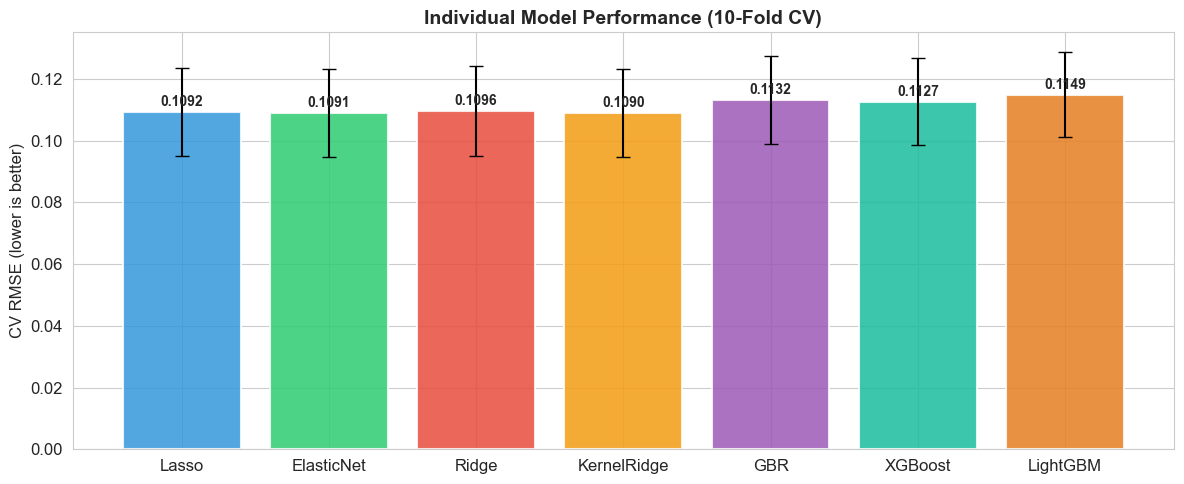

In [40]:
X_train = train_processed.values
X_test = test_processed.values

models = {
    'Lasso': lasso,
    'ElasticNet': enet,
    'Ridge': ridge,
    'KernelRidge': krr,
    'GBR': gbr,
    'XGBoost': xgb_model,
    'LightGBM': lgb_model,
}

results = {}
print(f'{"Model":<15} {"CV RMSE Mean":>14} {"CV RMSE Std":>14}')
print('=' * 45)

for name, model in models.items():
    score = cv_rmse(model, X_train, y_train)
    results[name] = score
    print(f'{name:<15} {score.mean():>14.6f} {score.std():>14.6f}')

# Visualization
fig, ax = plt.subplots(figsize=(12, 5))
means = [results[m].mean() for m in models]
stds = [results[m].std() for m in models]
colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12', '#9b59b6', '#1abc9c', '#e67e22']

bars = ax.bar(list(models.keys()), means, yerr=stds, capsize=5, 
              color=colors, alpha=0.85, edgecolor='white', linewidth=1.5)
ax.set_ylabel('CV RMSE (lower is better)', fontsize=12)
ax.set_title('Individual Model Performance (10-Fold CV)', fontsize=14, fontweight='bold')

for bar, mean in zip(bars, means):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
            f'{mean:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

## 8. Stacking Ensemble

### Strategy

We combine all 7 models using **stacking** with a Ridge meta-learner. The key insight is that different models make different types of errors — by combining them, we reduce overall variance.

**Final prediction formula:**
```
Final = 0.70 × Stacked_Prediction + 0.15 × XGBoost + 0.15 × LightGBM
```

This blend gives 70% weight to the diverse stacking ensemble while keeping 30% for the strongest individual boosting models.

In [41]:
# ============================================================
# Define Stacking Ensemble
# ============================================================
estimators = [
    ('lasso', lasso),
    ('enet', enet),
    ('ridge', ridge),
    ('krr', krr),
    ('gbr', gbr),
    ('xgb', xgb_model),
    ('lgb', lgb_model),
]

stack = StackingRegressor(
    estimators=estimators,
    final_estimator=Ridge(alpha=6.0),
    cv=kf,
    n_jobs=-1,
    passthrough=False
)

# Evaluate stacking ensemble
stack_score = cv_rmse(stack, X_train, y_train)
print(f'\nStacking Ensemble CV RMSE: {stack_score.mean():.6f} ± {stack_score.std():.6f}')


Stacking Ensemble CV RMSE: 0.106397 ± 0.013863


## 9. Final Training & Prediction

In [42]:
# ============================================================
# Train all models on full training set
# ============================================================
print('Training Stacking Ensemble on full training set...')
stack.fit(X_train, y_train)

print('Training XGBoost on full training set...')
xgb_model.fit(X_train, y_train)

print('Training LightGBM on full training set...')
lgb_model.fit(X_train, y_train)

# ============================================================
# Generate predictions (in log-space)
# ============================================================
print('\nGenerating predictions...')
pred_stack = stack.predict(X_test)
pred_xgb = xgb_model.predict(X_test)
pred_lgb = lgb_model.predict(X_test)

# ============================================================
# Blend predictions
# ============================================================
WEIGHT_STACK = 0.70
WEIGHT_XGB = 0.15
WEIGHT_LGB = 0.15

log_predictions = (
    WEIGHT_STACK * pred_stack + 
    WEIGHT_XGB * pred_xgb + 
    WEIGHT_LGB * pred_lgb
)

# Inverse log-transform
final_predictions = np.expm1(log_predictions)

# Safety: ensure no negative prices
final_predictions = np.maximum(final_predictions, 0)

print(f'\nPredictions generated for {len(final_predictions)} test houses.')
print(f'\nPrediction Statistics:')
print(f'   Min:    ${final_predictions.min():>12,.0f}')
print(f'   Median: ${np.median(final_predictions):>12,.0f}')
print(f'   Mean:   ${final_predictions.mean():>12,.0f}')
print(f'   Max:    ${final_predictions.max():>12,.0f}')

Training Stacking Ensemble on full training set...
Training XGBoost on full training set...
Training LightGBM on full training set...

Generating predictions...

Predictions generated for 1459 test houses.

Prediction Statistics:
   Min:    $      43,036
   Median: $     156,364
   Mean:   $     178,512
   Max:    $     716,055


## 10. Prediction Analysis

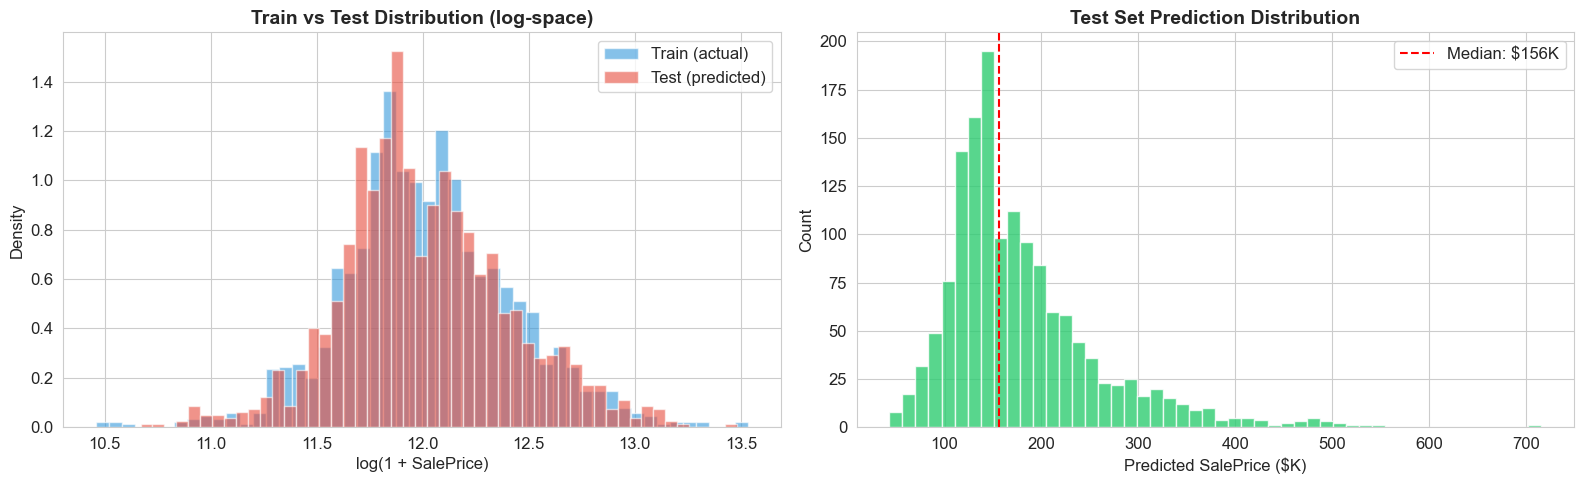

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Distribution comparison
axes[0].hist(np.log1p(train['SalePrice']), bins=50, alpha=0.6, 
             label='Train (actual)', color='#3498db', density=True)
axes[0].hist(log_predictions, bins=50, alpha=0.6, 
             label='Test (predicted)', color='#e74c3c', density=True)
axes[0].set_xlabel('log(1 + SalePrice)')
axes[0].set_ylabel('Density')
axes[0].set_title('Train vs Test Distribution (log-space)', fontsize=14, fontweight='bold')
axes[0].legend()

# Prediction distribution in dollar space
axes[1].hist(final_predictions / 1000, bins=50, color='#2ecc71', alpha=0.8, edgecolor='white')
axes[1].set_xlabel('Predicted SalePrice ($K)')
axes[1].set_ylabel('Count')
axes[1].set_title('Test Set Prediction Distribution', fontsize=14, fontweight='bold')
axes[1].axvline(np.median(final_predictions)/1000, color='red', linestyle='--', 
                label=f'Median: ${np.median(final_predictions)/1000:.0f}K')
axes[1].legend()

plt.tight_layout()
plt.show()

## 11. Submission

In [44]:
# ============================================================
# Create submission file
# ============================================================
submission = pd.DataFrame({
    'Id': test.index,
    'SalePrice': final_predictions
})

submission.to_csv('submission.csv', index=False)

print('Submission file saved: submission.csv')
print(f'\n   Rows: {len(submission):,}')
print(f'   Format: Id, SalePrice')
print(f'\n   Preview:')
submission.head(10)

Submission file saved: submission.csv

   Rows: 1,459
   Format: Id, SalePrice

   Preview:


,Id,SalePrice
0,1461,120110.676290
1,1462,157269.101804
2,1463,182390.962710
3,1464,196849.186228
4,1465,194145.647788
5,1466,171864.132401
6,1467,177606.126046
7,1468,164863.833354
8,1469,186690.364955
9,1470,122655.949020
